In [261]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import itertools
from keras.backend import clear_session
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import keras
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [253]:
with open('./data.txt') as f:
    sentences=[line[:-1].split(";") for line in f.readlines()]
sentences[1999][1]='fear'

In [263]:
df=pd.DataFrame(sentences)
df=df.rename(columns={0:"sentence",1:"emotion"})

set(df["emotion"])
dic={'anger':0, 'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}
df['emotion']=[*map(dic.get, df['emotion'])]

In [264]:
vectorizer=CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(df["sentence"])
sentences_train, sentences_test, emotion_train, emotion_test=train_test_split(df["sentence"],df["emotion"],test_size=.25)
X_train=vectorizer.transform(sentences_train).toarray()
X_test=vectorizer.transform(sentences_test).toarray()
y_train=emotion_train
y_test=emotion_test

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [259]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

Training Accuracy: 0.9920
Testing Accuracy:  0.6780


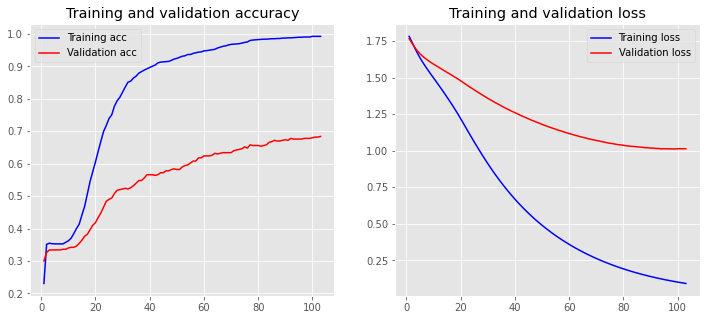

In [265]:
clear_session()
input_dim = X_train.shape[1]  
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.compile(loss="CategoricalCrossentropy", 
            optimizer=keras.optimizers.Adam(learning_rate=.0001), 
            metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=150,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=[callback]
                    )
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [269]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)
print(classification_report(emotion_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.49      0.58        79
           1       0.72      0.55      0.63        56
           2       0.67      0.86      0.75       167
           3       0.55      0.30      0.39        37
           4       0.68      0.81      0.74       141
           5       0.50      0.05      0.09        20

    accuracy                           0.68       500
   macro avg       0.64      0.51      0.53       500
weighted avg       0.67      0.68      0.65       500



The fact that the data is imbalanced makes the recalls pretty bad for low-support emotions. It's worth considering balancing the training data. 

More importantly, however, the neural net's topology is not very interesting. It needs some LSTM layers. The embedding is also completely naive. I'll fix these in the future.